<a href="https://colab.research.google.com/github/ProjectXMG999/ProjectXMG999-NLP-Text-generation-classification/blob/main/Sentiment_LSTMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training with Bidirectional LSTM 
- working again with reviews from amazon and yelp
- predictinh sentiment of new reviews
- experimenting with embedding vs Bidirectional LSTMs vs multiple bidirectional layers

- copmaring:
    - Embeddings and a Global Average Pooling layer
    - Embeddings and a Bidirectional LSTM layer
    - Embeddings and two Bidirectional LSTM layers

In [1]:
import tensorflow as tf
from keras.utils import pad_sequences
import pandas as pd
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P -O /tmp/sentiment.csv

--2023-03-09 20:58:45--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 64.233.191.138, 64.233.191.100, 64.233.191.101, ...
Connecting to drive.google.com (drive.google.com)|64.233.191.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6nr2js8hd783iv75io3fe8ihsb0fskb5/1678395525000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=aef37791-49e3-476d-89b2-51d7f0ecc774 [following]
--2023-03-09 20:58:46--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6nr2js8hd783iv75io3fe8ihsb0fskb5/1678395525000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=aef37791-49e3-476d-89b2-51d7f0ecc774
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 173.194.192.132, 2607:f8b0:4001:c0e::84
Connecting to doc-0

In [3]:
dataset = pd.read_csv('/tmp/sentiment.csv')

# Extract out sentences and labels
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

# Print some example sentences and labels
for x in range(2):
  print(sentences[x])
  print(labels[x])
  print("\n")

So there is no way for me to plug it in here in the US unless I go by a converter.
0


Good case Excellent value.
1




In [4]:
# create a subwords dataset
vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length=5)

# How big is the vocab size?
print("Vocab size is ", tokenizer.vocab_size)

Vocab size is  999


In [5]:
# Check that the tokenizer works appropriately
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


In [6]:
# Separately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]))

I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


In [7]:
# Replace sentence data with encoded subwords

for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

# Check the sentences are appropriately replaced
print(sentences[5])

[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]


In [ ]:
# Final pre-processing

In [8]:

max_length = 50
trunc_type='post'
padding_type='post'

# Pad all sequences
sequences_padded = pad_sequences(sentences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sequences = sequences_padded[0:training_size]
testing_sequences = sequences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

## Create the model using an Embedding

In [9]:
embedding_dim = 16

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), 
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            16000     
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 16,109
Trainable params: 16,109
Non-trainable params: 0
_________________________________________________________________


In [10]:
# train the model

num_epochs = 30
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, validation_data=(testing_sequences, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 2s 13ms/step - loss: 0.6923 - accuracy: 0.5166 - val_loss: 0.6953 - val_accuracy: 0.4135
Epoch 2/30
50/50 [==============================] - 0s 7ms/step - loss: 0.6890 - accuracy: 0.5267 - val_loss: 0.6985 - val_accuracy: 0.4160
Epoch 3/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6830 - accuracy: 0.5436 - val_loss: 0.6963 - val_accuracy: 0.4411
Epoch 4/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6723 - accuracy: 0.5863 - val_loss: 0.6853 - val_accuracy: 0.5163
Epoch 5/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6555 - accuracy: 0.6522 - val_loss: 0.6696 - val_accuracy: 0.5689
Epoch 6/30
50/50 [==============================] - 0s 5ms/step - loss: 0.6291 - accuracy: 0.7250 - val_loss: 0.6513 - val_accuracy: 0.6341
Epoch 7/30
50/50 [==============================] - 0s 5ms/step - loss: 0.5957 - accuracy: 0.7684 - val_loss: 0.6148 - val_accuracy: 0.7694
Epoch 8/30
50/50 [=

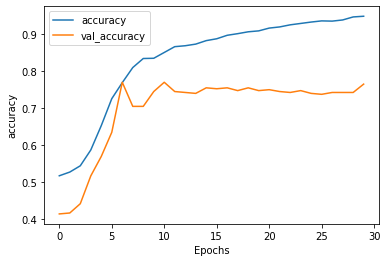

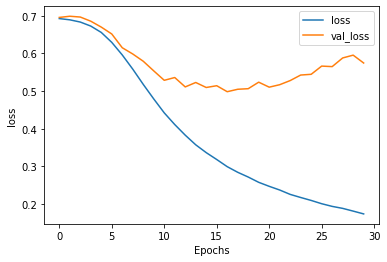

In [11]:
# plot the accuracy and lost

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [12]:
# define a function to predict the sentiment of reviews
# the higher the sentiment value is to 1, the more positive the review is

# max_length = 100 # previously defined

def predict_review(model, new_sentences, maxlen=max_length, show_padded_sequence=True ):
  # Keep the original sentences so that we can keep using them later
  # Create an array to hold the encoded sequences
  new_sequences = []

  # Convert the new reviews to sequences
  for i, frvw in enumerate(new_sentences):
    new_sequences.append(tokenizer.encode(frvw))

  trunc_type='post' 
  padding_type='post'

  # Pad all sequences for the new reviews
  new_reviews_padded = pad_sequences(new_sequences, maxlen=max_length, 
                                 padding=padding_type, truncating=trunc_type)             

  classes = model.predict(new_reviews_padded)

  # The closer the class is to 1, the more positive the review is
  for x in range(len(new_sentences)):
    
    # We can see the padded sequence if desired
    # Print the sequence
    if (show_padded_sequence):
      print(new_reviews_padded[x])
    # Print the review as text
    print(new_sentences[x])
    # Print its predicted class
    print(classes[x])
    print("\n")

In [13]:
# Use the model to predict some reviews   
fake_reviews = ["I love this phone", 
                "Everything was cold",
                "Everything was hot exactly as I wanted", 
                "Everything was green", 
                "the host seated us immediately",
                "they gave us free chocolate cake", 
                "we couldn't hear each other talk because of the shouting in the kitchen"
              ]

predict_review(model, fake_reviews)


1/1 [==============================] - 0s 187ms/step
[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.84017736]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.06752893]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.22825603]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everythin

In [14]:
# i want to compare models with different layers
# so i define function to rain and show the results each of them

def fit_model_now (model, sentences) :
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
  model.summary()
  history = model.fit(training_sequences, training_labels_final, epochs=num_epochs, 
                      validation_data=(testing_sequences, testing_labels_final))
  return history

def plot_results (history):
  plot_graphs(history, "accuracy")
  plot_graphs(history, "loss")

def fit_model_and_show_results (model, sentences):
  history = fit_model_now(model, sentences)
  plot_results(history)
  predict_review(model, sentences)

## add a bidirectional LSTM

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            16000     
                                                                 
 bidirectional (Bidirectiona  (None, 32)               4224      
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 6)                 198       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 20,429
Trainable params: 20,429
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
50/50 [==============================] - 9s 94ms/step - loss: 0.6909 - accuracy: 0.5085 - val_loss: 0.692

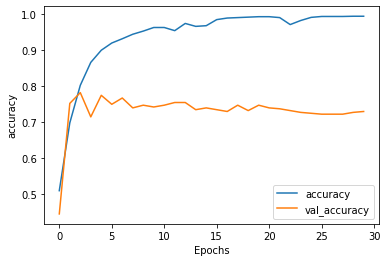

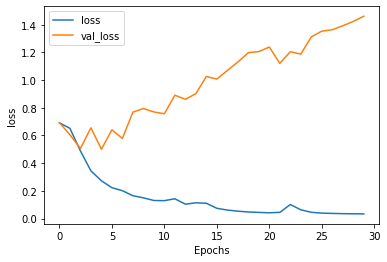

1/1 [==============================] - 1s 1s/step
[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.99797434]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.0192579]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.65653676]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything wa

In [15]:
# Define the model
model_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)), 
    tf.keras.layers.Dense(6, activation='relu'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile and train the model and then show the predictions for our extra sentences
fit_model_and_show_results(model_bidi_lstm, fake_reviews)

## use multiple bidirectional layers

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            16000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 50, 32)           4224      
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 6)                 198       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 26,701
Trainable params: 26,701
Non-trai

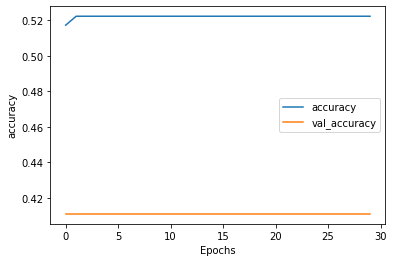

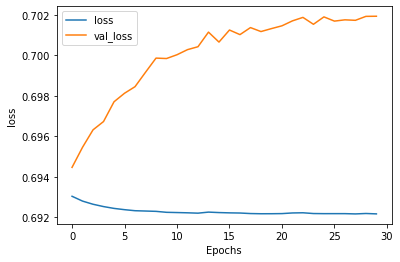

1/1 [==============================] - 3s 3s/step
[  4 281  16  25   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
I love this phone
[0.5219779]


[812 227 864 100 775   9 525 843   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was cold
[0.5219779]


[812 227 864 100 775   9 109   8 333 731  24  61   4 171  59  77   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was hot exactly as I wanted
[0.5219779]


[812 227 864 100 775   9 157 359 853   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Everything was 

In [16]:
model_multiple_bidi_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, 
                                                       return_sequences=True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

fit_model_and_show_results(model_multiple_bidi_lstm, fake_reviews)

In [17]:
# adding more reviews for fun

my_reviews =["lovely", "dreadful", "stay away",
             "everything was hot exactly as I wanted",
             "everything was not exactly as I wanted",
             "they gave us free chocolate cake",
             "I've never eaten anything so spicy in my life, my throat burned for hours",
             "for a phone that is as expensive as this one I expect it to be much easier to use than this thing is",
             "we left there very full for a low price so I'd say you just can't go wrong at this place",
             "that place does not have quality meals and it isn't a good place to go for dinner",
             ]

In [18]:
print("===================================\n","Embeddings only:\n", "===================================",)
predict_review(model, my_reviews, show_padded_sequence=False)

 Embeddings only:
1/1 [==============================] - 0s 29ms/step
lovely
[0.87649816]


dreadful
[0.20169482]


stay away
[0.5093937]


everything was hot exactly as I wanted
[0.6632323]


everything was not exactly as I wanted
[0.41680935]


they gave us free chocolate cake
[0.5920946]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.01389599]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.47690645]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.7020407]


that place does not have quality meals and it isn't a good place to go for dinner
[0.8092877]




In [19]:
print("===================================\n", "With a single bidirectional LSTM:\n", "===================================")
predict_review(model_bidi_lstm, my_reviews, show_padded_sequence=False)

 With a single bidirectional LSTM:
1/1 [==============================] - 0s 56ms/step
lovely
[0.9978633]


dreadful
[0.00907802]


stay away
[0.04634877]


everything was hot exactly as I wanted
[0.88915974]


everything was not exactly as I wanted
[0.01070927]


they gave us free chocolate cake
[0.9985673]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.06758616]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.00928407]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.99989134]


that place does not have quality meals and it isn't a good place to go for dinner
[0.00932208]




In [20]:
print("===================================\n","With two bidirectional LSTMs:\n", "===================================")
predict_review(model_multiple_bidi_lstm, my_reviews, show_padded_sequence=False)

 With two bidirectional LSTMs:
1/1 [==============================] - 0s 59ms/step
lovely
[0.5219779]


dreadful
[0.5219779]


stay away
[0.5219779]


everything was hot exactly as I wanted
[0.5219779]


everything was not exactly as I wanted
[0.5219779]


they gave us free chocolate cake
[0.5219779]


I've never eaten anything so spicy in my life, my throat burned for hours
[0.5219779]


for a phone that is as expensive as this one I expect it to be much easier to use than this thing is
[0.5219779]


we left there very full for a low price so I'd say you just can't go wrong at this place
[0.5219779]


that place does not have quality meals and it isn't a good place to go for dinner
[0.5219779]


